In [1]:
from typing import Any, Dict
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split

from architecture.classifier import DeepBinaryClassifier
from architecture.nodes.ripper import make_ripper_node
from architecture.utils import describe_architecture

In [2]:
dataset_df = pd.read_csv("./data/10_bit_artificial/107.csv")
input_values = dataset_df.drop(columns="class").to_numpy(bool)
target_values = dataset_df["class"].to_numpy(bool)

input_values_train, input_values_test, target_values_train, target_values_test \
    = train_test_split(input_values, target_values, test_size=0.2, random_state=42, stratify=target_values)

print("Dataset shapes:")
print(f"TRAIN | input: {input_values_train.shape}, target: {target_values_train.shape}, pos. frac.: {target_values_train.mean():.3f}")
print(f"TEST  | input: {input_values_test.shape}, target: {target_values_test.shape}, pos. frac.: {target_values_test.mean():.3f}")

Dataset shapes:
TRAIN | input: (819, 10), target: (819,), pos. frac.: 0.617
TEST  | input: (205, 10), target: (205,), pos. frac.: 0.620


In [3]:
config = dict(
    layer_node_counts=[8]*3 + [1],
    layer_bit_counts=[4]*4,
    seed=42
)

net = DeepBinaryClassifier(**config, node_factory=make_ripper_node, jobs=8)
%time net.fit(input_values_train, target_values_train)
pred_values_test = net.predict(input_values_test)
accuracies_test = (pred_values_test == target_values_test).mean(axis=0)
print(f"Accuracy on test set: {accuracies_test:.6f}")

CPU times: user 52.7 ms, sys: 126 ms, total: 178 ms
Wall time: 4.7 s
Accuracy on test set: 0.848780


In [4]:
def reduce_ripper_net(net) -> "DeepBinaryClassifier":
    for layer in net.layers:
        for node in layer:
            if hasattr(node, "reduce_expression"):
                node.reduce_expression()
    return net


red_net = reduce_ripper_net(net)
red_net.prune()

In [5]:
def print_architecture(desc: Dict[str, Any]) -> None:
    first_backlinks = [b for n in desc["layers"][1]["nodes"] for b in n["backlinks"]]
    used_inputs = sorted(set(first_backlinks))

    print("Used Inputs:", ", ".join(used_inputs))
    print("Layers & backlinks:")
    for layer in desc["layers"][1:]:  # skip input layer
        print(f"  {layer['name']}: {len(layer['nodes'])} node(s)")
        for n in layer["nodes"]:
            print(f"    {n['name']} - {n['backlinks']}")


desc = describe_architecture(net)
print_architecture(desc)

Used Inputs: L0N1, L0N2, L0N3, L0N5, L0N6, L0N7, L0N8, L0N9
Layers & backlinks:
  L1: 6 node(s)
    L1N0 - ['L0N1', 'L0N9']
    L1N1 - ['L0N1', 'L0N8']
    L1N2 - ['L0N1', 'L0N6', 'L0N7', 'L0N8']
    L1N3 - ['L0N2', 'L0N3', 'L0N7']
    L1N6 - ['L0N1']
    L1N7 - ['L0N1', 'L0N5', 'L0N6', 'L0N9']
  L2: 5 node(s)
    L2N0 - ['L1N0', 'L1N2']
    L2N4 - ['L1N0']
    L2N5 - ['L1N2', 'L1N7']
    L2N6 - ['L1N0', 'L1N1', 'L1N2', 'L1N3']
    L2N7 - ['L1N3', 'L1N6', 'L1N7']
  L3: 2 node(s)
    L3N1 - ['L2N6']
    L3N5 - ['L2N0', 'L2N4', 'L2N5', 'L2N7']
  OUTPUT: 1 node(s)
    L4N0 - ['L3N1', 'L3N5']


In [6]:
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "font.family": "serif",
    "font.weight": "bold"
})

def format_subscripts(name: str) -> str:
    """Format digits in names as subscripts (e.g. L2N7 -> $N_{7}$)."""
    return "$" + re.sub(r"([A-Za-z]+)(\d+)", r"\1_{\2}", name) + "$"

def plot_architecture_networkx(
        desc,
        *,
        layer_separation: float = 3.2,
        node_separation: float = 1.35,
        node_font_size: float = 12.0,
        header_font_size: float = 14.0,
        edge_width: float = 1.6,
        dpi: int = 120
):
    layers = desc["layers"]

    graph = nx.DiGraph()
    node_positions, node_labels = {}, {}

    for layer_idx, layer in enumerate(layers):
        num_nodes = len(layer["nodes"])
        node_y_positions = (np.arange(num_nodes)[::-1] - (num_nodes - 1) / 2.0) * node_separation
        node_x_positions = np.full(num_nodes, layer_idx * layer_separation)

        for node_idx, node in enumerate(layer["nodes"]):
            node_name = node["name"]
            node_positions[node_name] = (node_x_positions[node_idx], node_y_positions[node_idx])

            node_label = "N" + node_name.split("N", 1)[1]
            node_labels[node_name] = format_subscripts(node_label)

            for backlink in node.get("backlinks", []):
                if backlink in node_positions:
                    graph.add_edge(backlink, node_name)

    graph.add_nodes_from(node_positions)

    # layout and plot
    node_area = (node_font_size * 2.4) ** 2
    x_padding = 0.6 * layer_separation
    y_padding = 0.8 * node_separation
    header_offset = 0.6 * node_separation

    num_layers = max(1, len(layers))
    node_y_positions = [pos[1] for pos in node_positions.values()] or [0.0]
    node_y_min, node_y_max = min(node_y_positions), max(node_y_positions)
    node_x_min, node_x_max = -x_padding, (num_layers - 1) * layer_separation + x_padding
    node_y_min, node_y_max = node_y_min - y_padding, node_y_max + y_padding + header_offset

    figsize = ((node_x_max - node_x_min) * 0.90, (node_y_max - node_y_min) * 0.86)
    face_color = "white"
    draw_color = "black"

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_facecolor(face_color)

    nx.draw_networkx_edges(graph, node_positions, width=edge_width,
                           edge_color=draw_color, arrows=False, ax=ax, alpha=0.95)
    nx.draw_networkx_nodes(graph, node_positions, node_size=node_area,
                           node_color=face_color, edgecolors=draw_color, linewidths=edge_width, ax=ax)
    nx.draw_networkx_labels(graph, node_positions, labels=node_labels,
                            font_size=node_font_size, font_weight="bold", font_color=draw_color, ax=ax)

    ax.set_xlim(node_x_min, node_x_max)
    ax.set_ylim(node_y_min, node_y_max)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    # headers
    layer_titles = [format_subscripts(layer["name"]) for layer in layers]
    header_y_position = max(node_y_positions) + y_padding * 0.4 + header_offset

    for layer_idx, title in enumerate(layer_titles):
        header_x_position = layer_idx * layer_separation
        ax.text(header_x_position, header_y_position, title, ha="center", va="bottom",
                color=draw_color, fontweight="bold", fontsize=header_font_size)

    return fig, ax

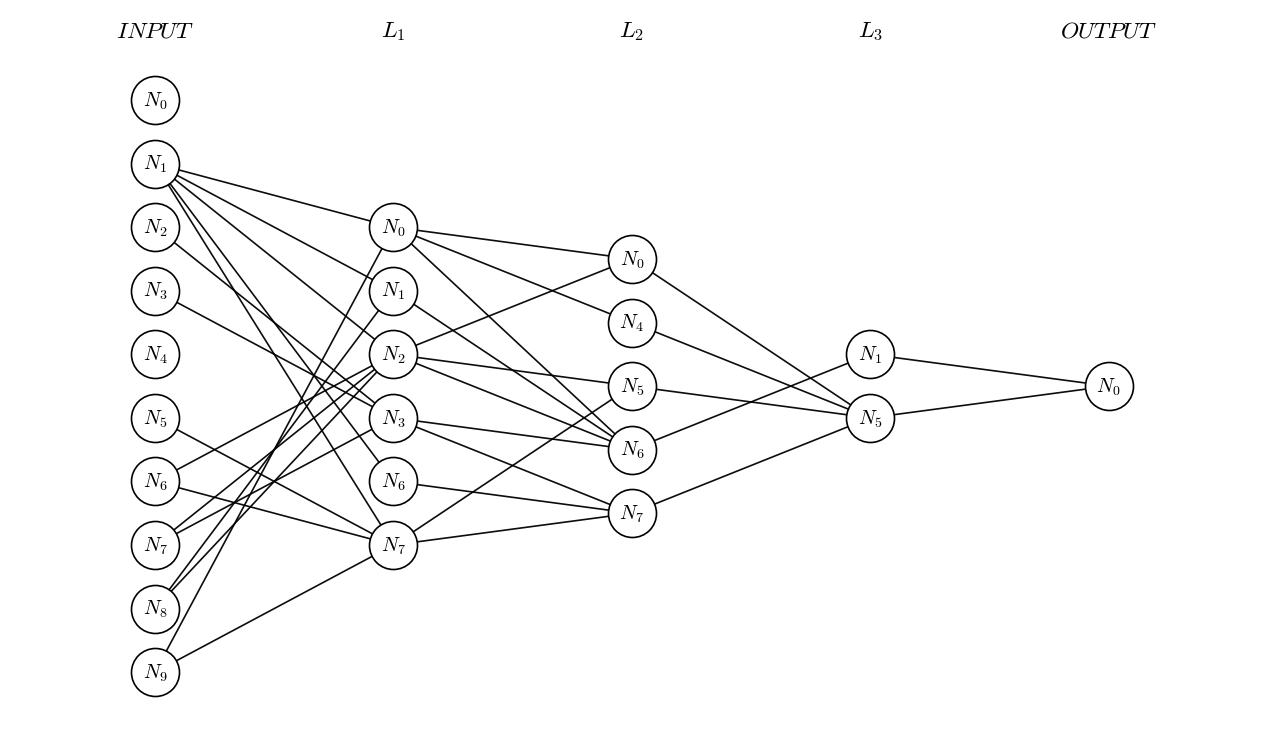

In [7]:
desc = describe_architecture(net)

fig, _ = plot_architecture_networkx(
    desc,
    layer_separation=3,
    node_separation=0.8,
    header_font_size = 14.0,
    edge_width=1,
)

In [8]:
node = net.layers[1][4]
node_truth_table, col_names = node.get_truth_table()
node_truth_table_df = pd.DataFrame(node_truth_table, columns=col_names)
print(node.get_expression())
node_truth_table_df

L1N7 | (L1N3 & L1N6)


,L1N3,L1N6,L1N7,L2N7 (output)
0,True,True,True,True
1,True,True,False,True
2,True,False,True,True
3,True,False,False,False
4,False,True,True,True
5,False,True,False,False
6,False,False,True,True
7,False,False,False,False
